<a href="https://colab.research.google.com/github/Tavares2020/Tavares2020/blob/main/08_advanced_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FICO Analytic Challenge © Fair Isaac 2025**

# Week 8: Advanced Feature Generation
Feature generation in neural networks for fraud detection involves creating sophisticated features to better identify fraudulent activities. By transforming raw data into meaningful inputs, we improve the model's ability to detect subtle patterns of fraud, enhancing its predictive accuracy and robustness.

Purpose of Feature Generation:
- Enhance detection by highlighting behaviors associated with fraud.
- Improve accuracy by providing the best possible data representations.

Types of Features for Fraud Detection:
- Temporal Features: Capture transaction timing and frequency to spot unusual patterns.
- Relational Features: Analyze relationships between transaction entities to uncover discrepancies.

In [ ]:
import os
import sys
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/', force_remount=True)

# Base path for your project
path = '/content/drive/MyDrive/FICO Analytic Challenge/'

# Folder that's holding dataset
data = 'Data'

# Model Folder's name
modelFolder='Model'

# Path to the "Data" and "Model" folder
data_path = os.path.join(path, data)

# Subdirectories to include in sys.path
subdirectories = [data, 'DNU_Functions', modelFolder] + [f'Week_{str(i).zfill(2)}' for i in range(12)]

# Add each subdirectory to sys.path
for subdir in subdirectories:
    sys.path.append(os.path.join(path, subdir))

# Change working directory to the base path
os.chdir(path)
print(os.getcwd())

Mounted at /content/drive/
/content/drive/MyDrive/FICO Analytic Challenge


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import math
from fico_functions import *
from IPython.display import display, Math, Latex, Image

# Plotting library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

# Removing limitation in viewing pandas columns and rows
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [ ]:
# dataset file prefix
trainFile = ['train']
testFile = ['test_A']

# Set to "True" if importing base dataset; default is False
base=False

# Set to "True" if creating advanced features and not base; default is False
creatingAdvancedFeatures=True

# Set to "True" if using advanced features, "False" if using regular features and not base; default is False
usingAdvancedFeatures=False

# CSV filename and where outputs will be saved
trainCSV, trainsaveCSV, featureTrainFileSuffix = featuresFileSuffix(data_path, trainFile, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)
testCSV, testsaveCSV, featureTestFileSuffix = featuresFileSuffix(data_path, testFile, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)

Only in Week 8
Using train_features.csv as input. Creating Advanced Features and saving all features to train_advanced_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/train_features.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/train_advanced_features.csv

Only in Week 8
Using test_A_features.csv as input. Creating Advanced Features and saving all features to test_A_advanced_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_A_features.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_A_advanced_features.csv



In [ ]:
#Upload pre-processed data
df1 = import_df(trainCSV)
df2 = import_df(testCSV)

In [ ]:
#Combine dataframes to be processed together
df = pd.concat([df1,df2], ignore_index=True, axis=0)

In [ ]:
#When reordering data, it's customary to reset the index to align with the order of the rows
df.sort_values(by=['pan','transactionDateTime'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['datetime'] =  pd.to_datetime(df['transactionDateTime'])

In [ ]:
# Look at the column names
df.columns

Index(['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last',
       'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState',
       'is_international', 'count_trend_1h', 'transactionHour',
       'is_late_night', 'is_high_repeat_amount', 'is_high_trans_freq',
       'transactionFrequency', 'is_high_amount', 'DistanceFlagkm',
       'is_high_online', 'num_last_24_hours', 'repeat_amt', 'user_avg_amount',
       'deltaTime', 'is_high_transaction_amount', 'num_transactions',
       'user_avg_volume', 'amount_diff', 'user_avg_amount_month',
       'user_avg_volume_month', 'is_high_transaction_amount_user_avg',
       'amt_trend_5e', 'RelativeAmount', 'is_high_inperson', 'category_ratio',
       'amt_trend_24h', 'IsHighValue', 'is_high_trans_freq_user_avg_

# Advanced Feature Generation for Credit Card Fraud Detection

Though we have already covered somewhat advanced features in week 4, there is still information to be squeezed from the data. We will investigate 3 key concepts in this notebook:
* Ratio Variables
* Exponential Weighting
* Repeat Events

## Ratio Variables

Ratio variables are perfect for detecting anomalies in spending patterns over time. The problem with simple "<font color='lightblue'>**last hour**</font>" or "<font color='lightblue'>**last day**</font>" variables is that you have no knowledge about this customer's habits outside of that specified timeframe. It's possible that the user naturally fluctuates rapidly throughout the day or week, but we're lacking the necessary long-period information. Typically you want the numerator to be something which encapsulates a time over which periodic behaviors can undergo a full cycle. For example: a user's spending habits might correlate with their pay cycle (2 weeks), or paying off their bills such as a car payment or rent (1 month). We don't want these non-fraud behaviors to trigger any alarm in our variables, so we make the numerator long enough for it to average out. On the other hand, we want our denominator to capture several of these cycles to ensure the numerator truly is reflective of that user's spending patterns.

In [ ]:
 # Example: rolling mean of last 14 days (2 weeks) vs. rolling mean of last 60 days (2 months)
df.set_index('datetime', inplace=True)  # Set the date column as the index
df['rolling_mean_14D'] = df.groupby('pan')['transactionAmount'].rolling(window='14D', min_periods=1).mean().reset_index(level=0, drop=True)
df['rolling_mean_60D'] = df.groupby('pan')['transactionAmount'].rolling(window='60D', min_periods=1).mean().reset_index(level=0, drop=True)
df['ratio_14D_to_60D'] = df['rolling_mean_14D'] / df['rolling_mean_60D']
df.reset_index(inplace=True)

If you want to alter the range of the window, simply change the window parameter in the rolling function. Here, we've specified '14D' and '60D' respectively. If you want to make a variable which goes over a window of a month, for instance, you could replace the parameter with '30D'

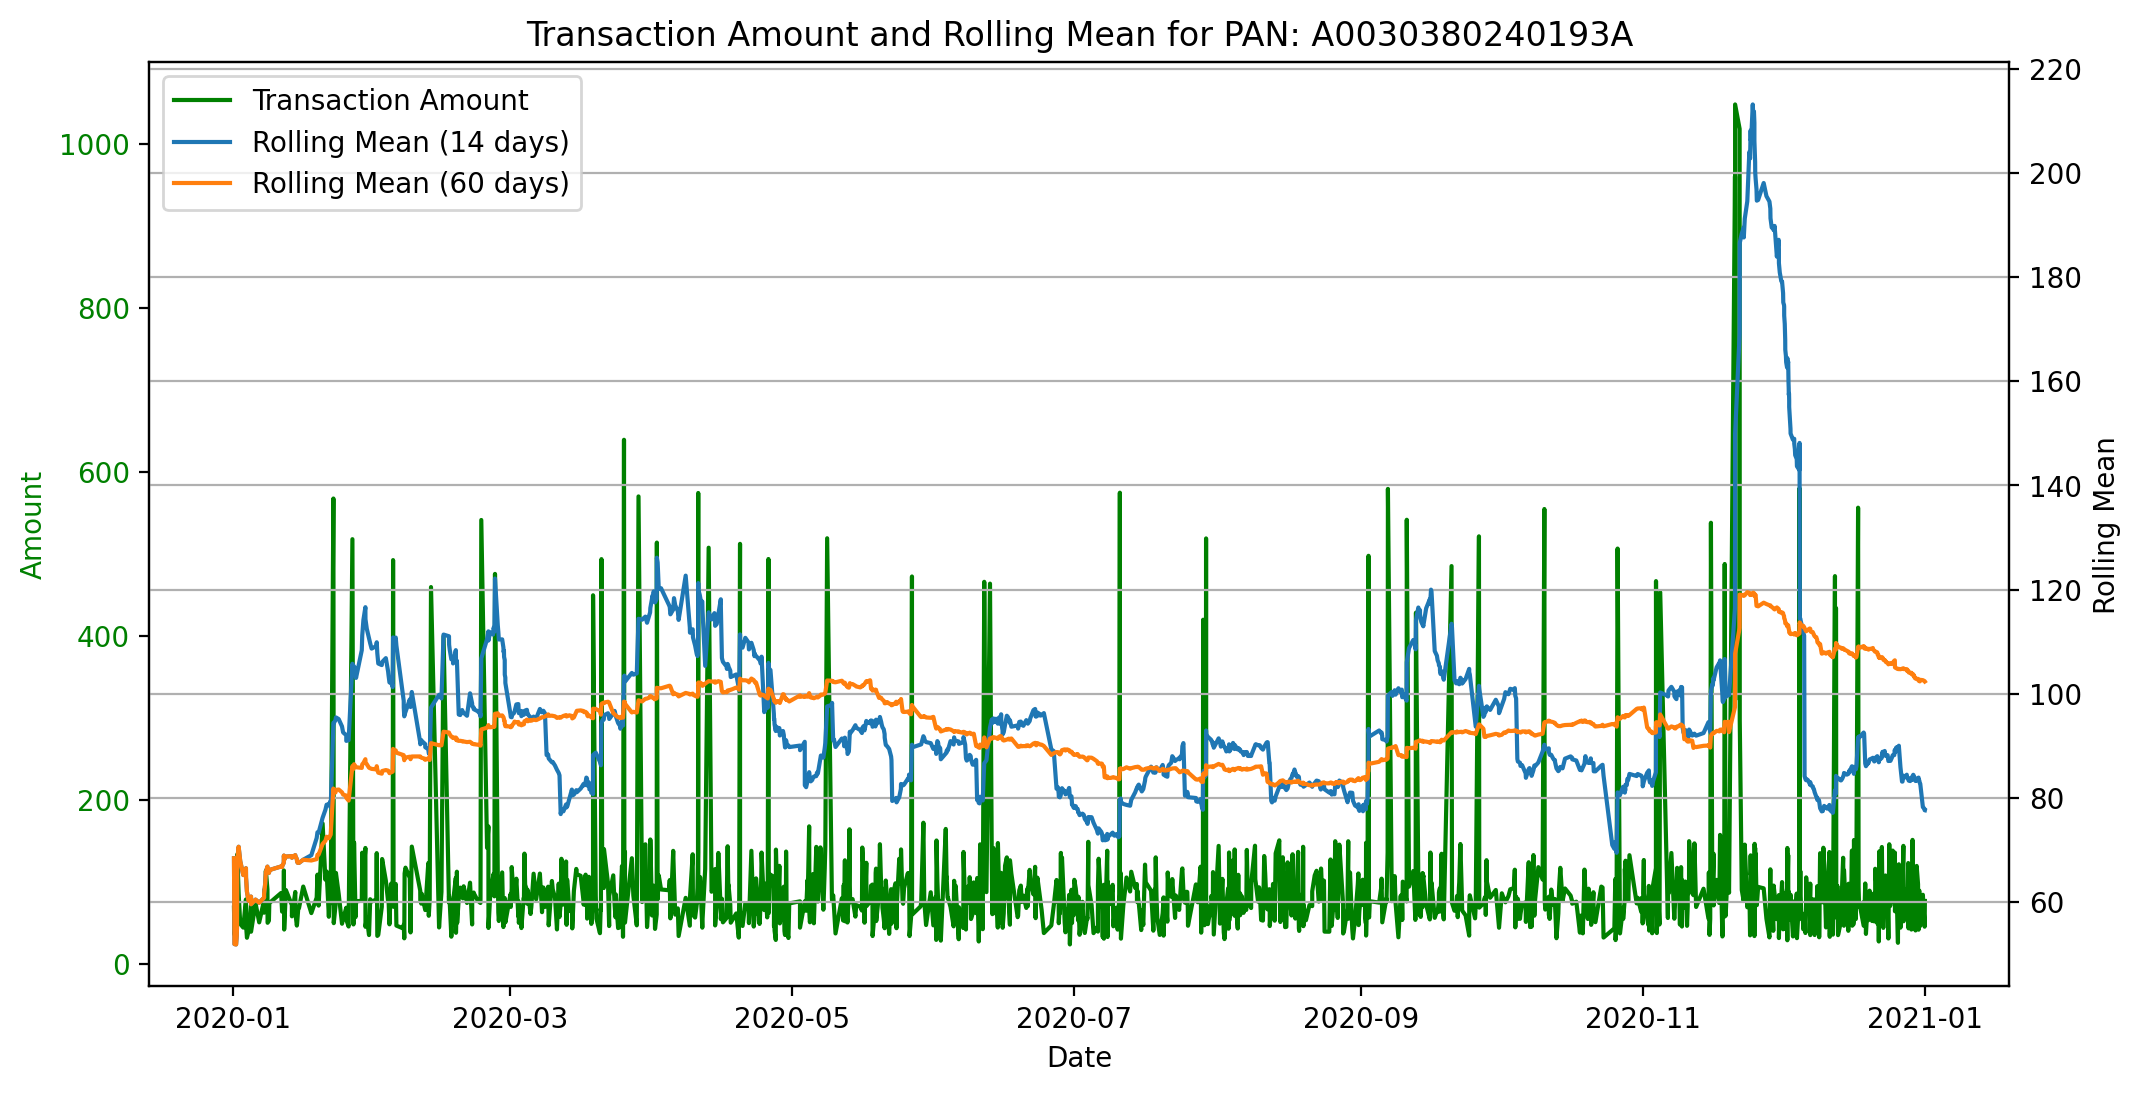

In [ ]:
# Visualizing ratio variables that we have calulated
pan_number = df['pan'].unique()[1]  # Select the second pan number for example
subset = df[df['pan'] == pan_number]

# Choose a time range (e.g., first 3 months)
start_date = subset['datetime'].min()
end_date = start_date + pd.DateOffset(months=3)
subset = subset[~((subset['datetime'] < start_date) & (subset['datetime'] > end_date))]

ax1Color='green'
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(subset['datetime'], subset['transactionAmount'], label='Transaction Amount', color=ax1Color)
ax1.set_xlabel('Date')
ax1.set_ylabel('Amount', color=ax1Color)
ax1.tick_params(axis='y', labelcolor=ax1Color)

ax2 = ax1.twinx()
ax2.plot(subset['datetime'], subset['rolling_mean_14D'], label='Rolling Mean (14 days)')
ax2.plot(subset['datetime'], subset['rolling_mean_60D'], label='Rolling Mean (60 days)')
ax2.set_ylabel('Rolling Mean')
ax2.tick_params(axis='y')

plt.title(f'Transaction Amount and Rolling Mean for PAN: {pan_number}')

# Get handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create the legend
plt.legend(handles, labels, loc='best')

plt.grid(True)
plt.show()

Now, let's visualize the ratio of the 14-day rolling average and 60 day rolling average. Calculating this ratio can highlight periods where the short-term trend is significantly different from the long-term trend, indicating potential anomalies, seasonal effects, or sudden changes in behavior.

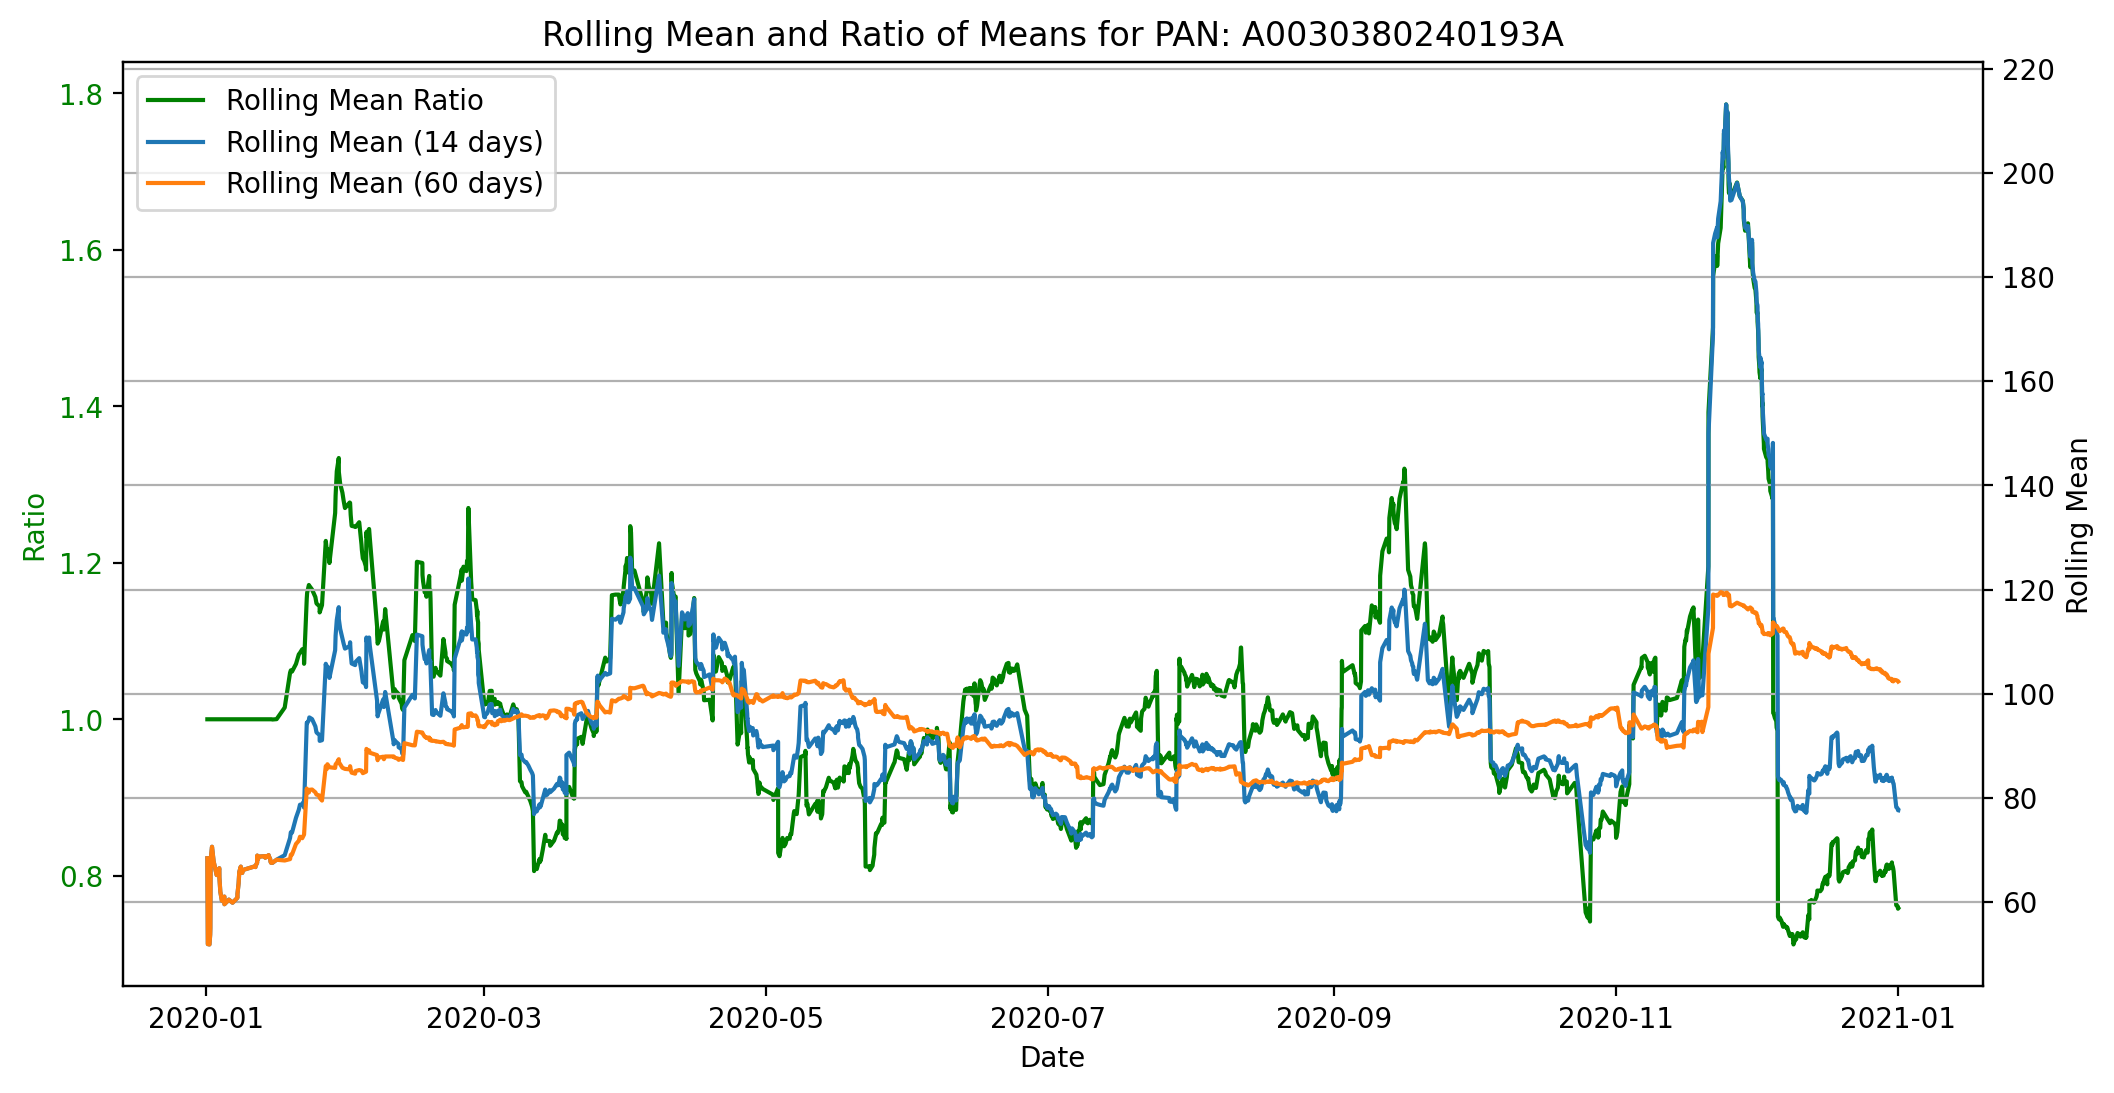

In [ ]:
# Visualizing ratio variables that we have calulated
pan_number = df['pan'].unique()[1]  # Select the second pan number for example
subset = df[df['pan'] == pan_number]

# Choose a time range (e.g., first 3 months)
start_date = subset['datetime'].min()
end_date = start_date + pd.DateOffset(months=3)
subset = subset[~((subset['datetime'] < start_date) & (subset['datetime'] > end_date))]


ax1Color='green'
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(subset['datetime'], subset['ratio_14D_to_60D'], label='Rolling Mean Ratio', color=ax1Color)
ax1.set_xlabel('Date')
ax1.set_ylabel('Ratio', color=ax1Color)
ax1.tick_params(axis='y', labelcolor=ax1Color)

ax2 = ax1.twinx()
ax2.plot(subset['datetime'], subset['rolling_mean_14D'], label='Rolling Mean (14 days)')
ax2.plot(subset['datetime'], subset['rolling_mean_60D'], label='Rolling Mean (60 days)')
ax2.set_ylabel('Rolling Mean')
ax2.tick_params(axis='y')

plt.title(f'Rolling Mean and Ratio of Means for PAN: {pan_number}')

# Get handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create the legend
plt.legend(handles, labels, loc='best')

plt.grid(True)
plt.show()

## Exponential Weighting

We have some notion of how to leverage long-term spending patterns to detect fraud, but what if we wanted to detect the instantaneous frauds as they're occurring? Exponential event and time decay are designed specifically for this task. By giving priority to the most recent transaction, we are able to detect fraud even sometimes on the very first fraud attempt, saving banks even more money.


### Below is an example of the exponential weighted mean function over time

In [ ]:
# Define halflife in Days
halflife = 1.  # Day

df['ewm_1D'] = df.groupby('pan').apply(
    lambda group: group['transactionAmount'].ewm(halflife=halflife, adjust=False).mean()
).reset_index(level=0, drop=True)

# Making sure that NaN values are replaced with zeros because they can cause
# issues with our rolling average calculations
# df = df.fillna(0)

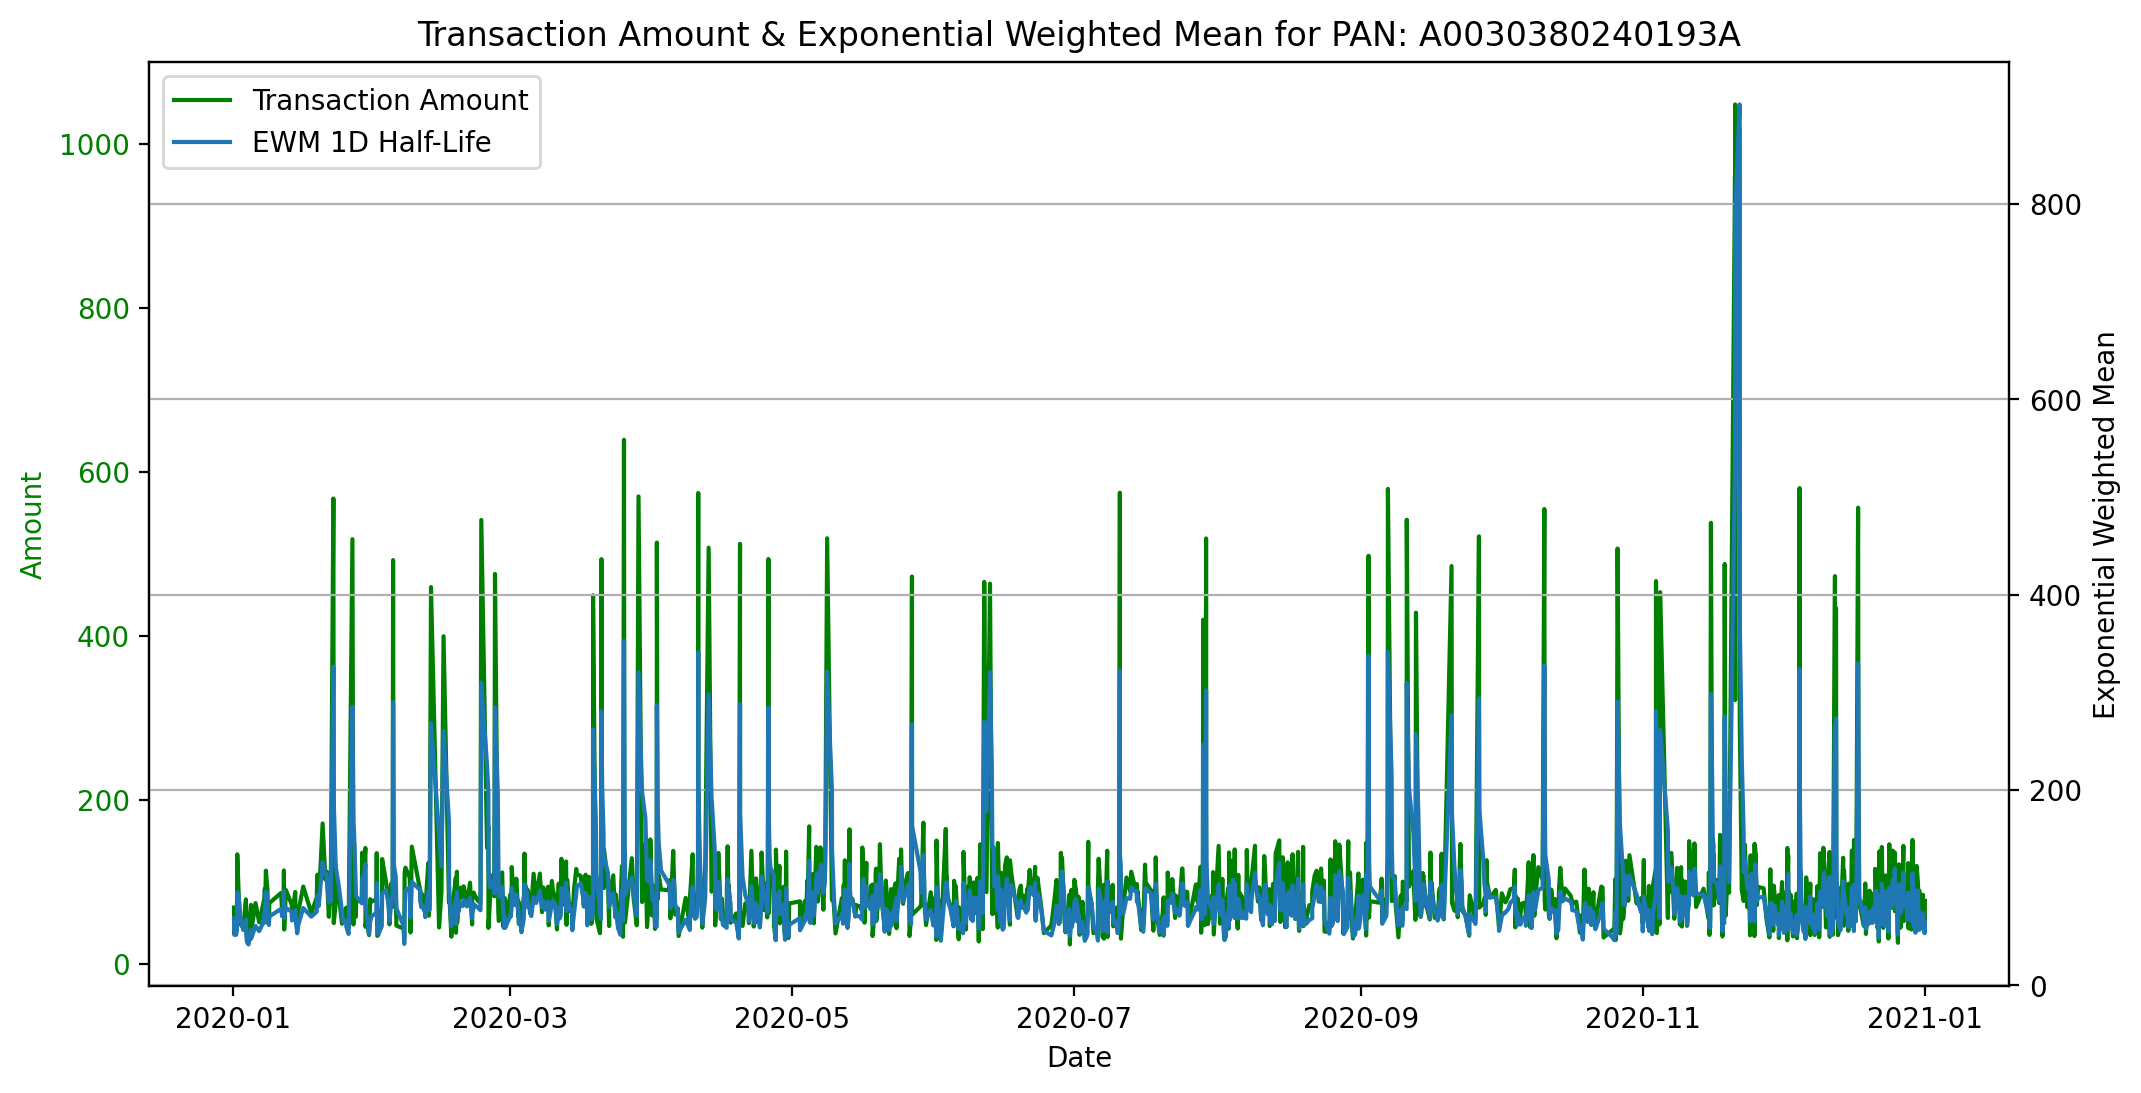

In [ ]:
# Visualizing ratio variables that we have calulated
pan_number = df['pan'].unique()[1]  # Select the second pan number for example
subset = df[df['pan'] == pan_number]

# Choose a time range (e.g., first 3 months)
start_date = subset['datetime'].min()
end_date = start_date + pd.DateOffset(months=3)
subset = subset[~((subset['datetime'] < start_date) & (subset['datetime'] > end_date))]

ax1Color='green'
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(subset['datetime'], subset['transactionAmount'], label='Transaction Amount', color=ax1Color)
ax1.set_xlabel('Date')
ax1.set_ylabel('Amount', color=ax1Color)
ax1.tick_params(axis='y', labelcolor=ax1Color)

ax2 = ax1.twinx()
ax2.plot(subset['datetime'], subset['ewm_1D'], label='EWM 1D Half-Life')
ax2.set_ylabel('Exponential Weighted Mean')
ax2.tick_params(axis='y')

plt.title(f'Transaction Amount & Exponential Weighted Mean for PAN: {pan_number}')

# Get handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create the legend
plt.legend(handles, labels, loc='best')

plt.grid(True)
plt.show()

Here, halflife (the time it takes for the value to decay to half) is a parameter which dictates how much you would like to prioritize more recent events. The larger halflife is, the less you prioritize recent events, and the smaller halflife is, the more you emphasize recent events.

# Different profile filters distinguish different basic profile variable types
Examples:
- Time Averages
- Repeats

# Time Averages
- Weighted average rate of change over time
- Weighting function gives
    - Unit weight to current time
    - Exponential suppression for earlier events, e.g.,
$$
  e^{\frac{(𝑡_{𝑛−1}−𝑡_{𝑛})}{𝑇}}
$$

# Repeats
- Counts how many repeat events have a specified property
- Normal repeat counting goes as 1, 2, 3, 4, ….
- Falcon uses exponentially decayed repeat counting
- If current event qualifies as repeats, then multiply prior count by $e^{-\frac{dt}{𝑇}}$ before adding 1
- If current event does not qualify as repeat, then reset variable to 0

In [ ]:
def compute_timedecay_rate(df, decay=3600, name = "time_decay"):
    avg_amount_list = []
    current_count_rate = 0
    current_amount_rate = 0
    current_pan = None

    for index, row in df.iterrows():
        DC = np.exp(-row["deltaTime"]/decay)
        if (row["pan"] != current_pan):
            current_pan = row["pan"]
            current_count_rate = 0
            current_amount_rate = 0
            DC = 0
        current_count_rate = 1 + current_count_rate*DC
        current_amount_rate = row["transactionAmount"] + current_amount_rate*DC
        avg_amount = current_amount_rate / current_count_rate
        avg_amount_list.append(avg_amount)
    df[name] = avg_amount_list

In [ ]:
def compute_hi_repeat(df, decay=60, name = "1d"):
    avg_amount_list = []
    current_count_rate = 0
    current_amount_rate = 0
    current_pan = None

    df['condition'] = False
    df.loc[df['transactionAmount'] > 100., 'condition'] = True

    for index, row in df.iterrows():
        if ((row["pan"] != current_pan) or (row['condition'] == False)):
            current_pan = row["pan"]
            current_count_rate = 0
            current_amount_rate = 0
        current_count_rate = 1 + current_count_rate*np.exp(-row["deltaTime"]/decay)
        current_amount_rate = row["transactionAmount"] + current_amount_rate*np.exp(-row["deltaTime"]/decay)
        avg_amount = current_amount_rate / current_count_rate
        avg_amount_list.append(avg_amount)

    df[name] = avg_amount_list
    df.drop(columns='condition',inplace=True)

In [ ]:
compute_timedecay_rate(df, decay=60, name = "1m")
compute_hi_repeat(df, decay=3600, name = "repeat_hi_amt_1H")

KeyboardInterrupt: 

In [ ]:
df[df['repeat_hi_amt_1H'] < df['transactionAmount']/3]['pan']

In [ ]:
# Visualizing ratio variables that we have calulated
pan_number = df['pan'].unique()[1]  # Select the second pan number for example
subset = df[df['pan'] == pan_number]

# Choose a time range (e.g., first 3 months)
start_date = subset['datetime'].min()
end_date = start_date + pd.DateOffset(months=3)
subset = subset[~((subset['datetime'] < start_date) & (subset['datetime'] > end_date))]

ax1Color='red'
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(subset['datetime'], subset['transactionAmount'], label='Transaction Amount', color=ax1Color, linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Amount', color=ax1Color)
ax1.tick_params(axis='y', labelcolor=ax1Color)

ax2Color='green'
ax2 = ax1.twinx()
ax2.plot(subset['datetime'], subset['1m'], label='Time Decay 1m', color=ax2Color, linewidth=0.5)
ax2.set_ylabel('Time Decay', color=ax2Color)
ax2.tick_params(axis='y', labelcolor=ax2Color)

plt.title(f'Transaction Amount & Time Decay for PAN: {pan_number}')

# Get handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create the legend
plt.legend(handles, labels, loc='best')

plt.grid(True)
plt.show()

In [ ]:
# Visualizing ratio variables that we have calulated
pan_number = df['pan'].unique()[1]  # Select the second pan number for example
subset = df[df['pan'] == pan_number]

# Choose a time range (e.g., first 3 months)
start_date = subset['datetime'].min()
end_date = start_date + pd.DateOffset(months=3)
subset = subset[~((subset['datetime'] < start_date) & (subset['datetime'] > end_date))]

ax1Color='red'
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(subset['datetime'], subset['transactionAmount'], label='Transaction Amount', color=ax1Color, linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Amount', color=ax1Color)
ax1.tick_params(axis='y', labelcolor=ax1Color)

ax2Color='green'
ax2 = ax1.twinx()
ax2.plot(subset['datetime'], subset['repeat_hi_amt_1H'], label='Repeat Hi Amount 1H', color=ax2Color, linewidth=0.5)
ax2.set_ylabel('Repeat Hi Amount', color=ax2Color)
ax2.tick_params(axis='y', labelcolor=ax2Color)

plt.title(f'Transaction Amount & Repeat Amount for PAN: {pan_number}')

# Get handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create the legend
plt.legend(handles, labels, loc='best')

plt.grid(True)
plt.show()

# Exercise
1. Create a feature that computes the rolling mean of last 30 days (1 month) vs. rolling mean of last 60 days (2 months), then create a ratio variable from these
2. Create a feature that computes the exponential weighted mean of the transaction amount with a half-life of four days


In [ ]:
nan_columns = df.columns[df.isna().any()]
print(f"Columns with NaN values: {nan_columns}")

for nanCol in nan_columns:
  num_nan = df[nanCol].isna().sum()
  print(f"The {nanCol} column contains {num_nan} NaN values.")

In [ ]:
def generateAdvancedFeatures(csvFile, saveFile):
    # Upload pre-processed data
    df = import_df(csvFile)

    # Ensure base_cols is a list of strings
    base_cols = list(map(str, df.columns))

    # Since many of our features will be calculated at the account level, let's sort our features accordingly
    df = df.sort_values(by=['pan', 'transactionDateTime'])

    # Create datetime
    df['datetime'] =  pd.to_datetime(df['transactionDateTime'])

    # RATIO Variable
    df.set_index('datetime', inplace=True)  # Set the datetime column as the index
    df['rolling_mean_14D'] = df.groupby('pan')['transactionAmount'].rolling(window='14D', min_periods=1).mean().reset_index(level=0, drop=True)
    df['rolling_mean_60D'] = df.groupby('pan')['transactionAmount'].rolling(window='60D', min_periods=1).mean().reset_index(level=0, drop=True)
    df['ratio_14D_to_60D'] = df['rolling_mean_14D'] / df['rolling_mean_60D']
    df.reset_index(inplace=True)

    # Exponential Weighting Variable
    # Define halflife in Days
    halflife = 1.  # Day

    df['ewm_1D'] = df.groupby('pan').apply(
        lambda group: group['transactionAmount'].ewm(halflife=halflife, adjust=False).mean()
    ).reset_index(level=0, drop=True)

    # Time Decay Variable
    def compute_timedecay_rate(df, decay=3600, name = "time_decay"):
        avg_amount_list = []
        current_count_rate = 0
        current_amount_rate = 0
        current_pan = None

        for index, row in df.iterrows():
            DC = np.exp(-row["deltaTime"]/decay)
            if (row["pan"] != current_pan):
                current_pan = row["pan"]
                current_count_rate = 0
                current_amount_rate = 0
                DC = 0

            current_count_rate = 1 + current_count_rate*DC
            current_amount_rate = row["transactionAmount"] + current_amount_rate*DC
            avg_amount = current_amount_rate / current_count_rate
            avg_amount_list.append(avg_amount)
        df[name] = avg_amount_list

    # Repeat Amount Variable
    def compute_hi_repeat(df, decay=60, name = "1d"):
        avg_amount_list = []
        current_count_rate = 0
        current_amount_rate = 0
        current_pan = None

        df['condition'] = False
        df.loc[df['transactionAmount'] > 100., 'condition'] = True

        for index, row in df.iterrows():
            if ((row["pan"] != current_pan) or (row['condition'] == False)):
                current_pan = row["pan"]
                current_count_rate = 0
                current_amount_rate = 0
            current_count_rate = 1 + current_count_rate*np.exp(-row["deltaTime"]/decay)
            current_amount_rate = row["transactionAmount"] + current_amount_rate*np.exp(-row["deltaTime"]/decay)
            avg_amount = current_amount_rate / current_count_rate
            avg_amount_list.append(avg_amount)

        df[name] = avg_amount_list
        df.drop(columns='condition',inplace=True)

    compute_timedecay_rate(df, decay=60, name = "1m")
    compute_hi_repeat(df, decay=3600, name = "repeat_hi_amt_1H")

    df.reset_index(drop=True, inplace=True)

    # ##########################################################################
    # ###################### STUDENTS Extra Features Start #####################
    # ##########################################################################

    if 'datetime' not in df.columns:
      df['datetime'] =  pd.to_datetime(df['transactionDateTime'])
      df = df.sort_values(by=['pan', 'transactionDateTime'])
      df.reset_index(drop=True, inplace=True)
    # =========================================================
    # ======= Features that DO NOT require 'datetime' as index
    # =========================================================
    # Exponential weighted mean over time with a half-life of 4 days
    # Define halflife in Days
    #halflife = #TODO

    #df['ewm_4D'] = #TODO

    # =========================================================
    # =========== Features that DO require 'datetime' as index
    # =========================================================
    df.set_index('datetime', inplace=True)

    # Rolling mean of last 30 days (1 month) vs. rolling mean of last 60 days (2 months)
    #df['rolling_mean_30D'] = #TODO
    #df['rolling_mean_60D'] = #TODO
    #df['ratio_30D_to_60D'] = #TODO

    # ##########################################################################
    # ###################### STUDENTS Extra Features END #######################
    # ##########################################################################
    df.reset_index(drop=True, inplace=True)

    # Ensure df.columns is a list of strings
    df_columns = list(map(str, df.columns))

    # Features to save
    if "datetime" in df.columns:
      features = list(set(df_columns) - set(base_cols + ["datetime"]))
    else:
      features = list(set(df_columns) - set(base_cols))

    saveFeatures = [*base_cols, *features]
    print(f"Features to save: {saveFeatures}")

    df[saveFeatures].to_csv(saveFile,index=False)

    return df

In [ ]:
# Dataset file prefix
File = ['train']

# Set to "True" if importing base dataset; default is False
base=False

# Set to "True" if creating advanced features; default is False
creatingAdvancedFeatures=True

# Set to "True" if using advanced features, "False" if using regular features and not base; default is False
usingAdvancedFeatures=False

# CSV filename and where outputs will be saved
CSV, saveCSV, _ = featuresFileSuffix(data_path, File, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)

Only in Week 8
Using train_features.csv as input. Creating Advanced Features and saving all features to train_advanced_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/train_features.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/train_advanced_features.csv



In [ ]:
df_temp = generateAdvancedFeatures(CSV, saveCSV)

Features to save: ['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last', 'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx', 'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry', 'merchState', 'cardholderCountry', 'cardholderState', 'is_international', 'count_trend_1h', 'transactionHour', 'is_late_night', 'is_high_repeat_amount', 'is_high_trans_freq', 'transactionFrequency', 'is_high_amount', 'DistanceFlagkm', 'is_high_online', 'num_last_24_hours', 'repeat_amt', 'user_avg_amount', 'deltaTime', 'is_high_transaction_amount', 'num_transactions', 'user_avg_volume', 'amount_diff', 'user_avg_amount_month', 'user_avg_volume_month', 'is_high_transaction_amount_user_avg', 'amt_trend_5e', 'RelativeAmount', 'is_high_inperson', 'category_ratio', 'amt_trend_24h', 'IsHighValue', 'is_high_trans_freq_user_avg_vol', 'user_avg_amount_week', 'is_CP', 'is_CNP', 'user_avg_volume_week', 'is_hi

In [ ]:
# Dataset file prefix
File = ['test_A']

# Set to "True" if importing base dataset; default is False
base=False

# Set to "True" if creating advanced features; default is False
creatingAdvancedFeatures=True

# Set to "True" if using advanced features, "False" if using regular features and not base; default is False
usingAdvancedFeatures=False

# CSV filename and where outputs will be saved
CSV, saveCSV, _ = featuresFileSuffix(data_path, File, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)

Only in Week 8
Using test_A_features.csv as input. Creating Advanced Features and saving all features to test_A_advanced_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_A_features.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_A_advanced_features.csv



In [ ]:
df_tempA = generateAdvancedFeatures(CSV, saveCSV)

Features to save: ['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last', 'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx', 'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry', 'merchState', 'cardholderCountry', 'cardholderState', 'is_international', 'count_trend_1h', 'transactionHour', 'is_late_night', 'is_high_repeat_amount', 'is_high_trans_freq', 'transactionFrequency', 'is_high_amount', 'DistanceFlagkm', 'is_high_online', 'num_last_24_hours', 'repeat_amt', 'user_avg_amount', 'deltaTime', 'is_high_transaction_amount', 'num_transactions', 'user_avg_volume', 'amount_diff', 'user_avg_amount_month', 'user_avg_volume_month', 'is_high_transaction_amount_user_avg', 'amt_trend_5e', 'RelativeAmount', 'is_high_inperson', 'category_ratio', 'amt_trend_24h', 'IsHighValue', 'is_high_trans_freq_user_avg_vol', 'user_avg_amount_week', 'is_CP', 'is_CNP', 'user_avg_volume_week', 'is_hi

In [ ]:
# Dataset file prefix
File = ['test_C_notags']

# Set to "True" if importing base dataset; default is False
base=False

# Set to "True" if creating advanced features; default is False
creatingAdvancedFeatures=True

# Set to "True" if using advanced features, "False" if using regular features and not base; default is False
usingAdvancedFeatures=False

# CSV filename and where outputs will be saved
CSV, saveCSV, _ = featuresFileSuffix(data_path, File, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)

Only in Week 8
Using test_C_notags_features.csv as input. Creating Advanced Features and saving all features to test_C_notags_advanced_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_C_notags_features.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_C_notags_advanced_features.csv



In [ ]:
df_tempC = generateAdvancedFeatures(CSV, saveCSV)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/FICO Analytic Challenge/Data/test_C_notags_features.csv'

In [ ]:
# Dataset file prefix
File = ['test_B']

# Set to "True" if importing base dataset; default is False
base=False

# Set to "True" if creating advanced features; default is False
creatingAdvancedFeatures=True

# Set to "True" if using advanced features, "False" if using regular features and not base; default is False
usingAdvancedFeatures=False

# CSV filename and where outputs will be saved
CSV, saveCSV, _ = featuresFileSuffix(data_path, File, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)

Only in Week 8
Using test_B_features.csv as input. Creating Advanced Features and saving all features to test_B_advanced_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_B_features.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_B_advanced_features.csv



In [ ]:
df_tempB = generateAdvancedFeatures(CSV, saveCSV)

Features to save: ['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last', 'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx', 'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry', 'merchState', 'cardholderCountry', 'cardholderState', 'RelativeAmount', 'is_high_person', 'count_trend_1h', 'amt_trend_24h', 'user_avg_amount_week', 'transactionHour', 'category_ratio', 'user_avg_volume', 'is_high_inperson', 'user_avg_amount_month', 'user_avg_volume_month', 'is_high_trans_freq', 'user_avg_volume_week', 'is_high_transaction_amount_user_avg', 'is_international', 'is_high_amount', 'is_CP', 'num_last_24_hours', 'deltaTime', 'is_high_trans_freq_user_avg_vol', 'is_high_transaction_amount', 'repeat_amt', 'is_high_repeat_amount', 'is_high_volume', 'amt_trend_5e', 'is_CNP', 'num_transactions', 'DistanceFlagkm', 'transactionFrequency', 'is_high_merch_country', 'amount_diff', 'num_hi_amt_la